In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_salary = pd.read_csv('./data/dataset_salary.csv')

In [3]:
df_salary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tempo_na_empresa  1000 non-null   int64  
 1   nivel_na_empresa  1000 non-null   int64  
 2   salario_em_reais  1000 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 23.6 KB


## EDA e Bucketing

In [4]:
df_salary_eda = df_salary.copy()
df_salary_bucketing = df_salary.copy()

## Análise exploratória

In [5]:
df_salary_eda.head(10)

,tempo_na_empresa,nivel_na_empresa,salario_em_reais
0,50,1,2288.13
1,49,4,2389.84
2,39,10,2158.73
3,51,1,2341.06
4,62,7,3584.20
5,105,10,12102.18
6,80,3,5723.35
7,85,2,6424.92
8,66,5,3916.18
9,73,5,4751.79


In [6]:
# Detectar valores ausentes

df_salary_eda.isna().sum()

tempo_na_empresa    0
nivel_na_empresa    0
salario_em_reais    0
dtype: int64

In [7]:
# Medidas estatísticas do DF

df_salary_eda.describe()

,tempo_na_empresa,nivel_na_empresa,salario_em_reais
count,1000.000000,1000.000000,1000.000000
mean,59.712000,5.467000,5093.726110
std,34.027679,2.889509,4536.168857
min,1.000000,1.000000,538.560000
25%,30.750000,3.000000,1537.477500
50%,60.000000,6.000000,3237.920000
75%,89.000000,8.000000,7436.680000
max,120.000000,10.000000,18923.230000


<Axes: xlabel='tempo_na_empresa'>

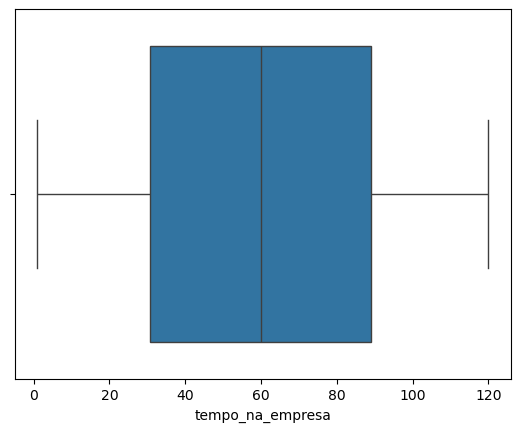

In [8]:
# Detectar outliers

sns.boxplot(data=df_salary_eda, x='tempo_na_empresa')

<Axes: xlabel='nivel_na_empresa'>

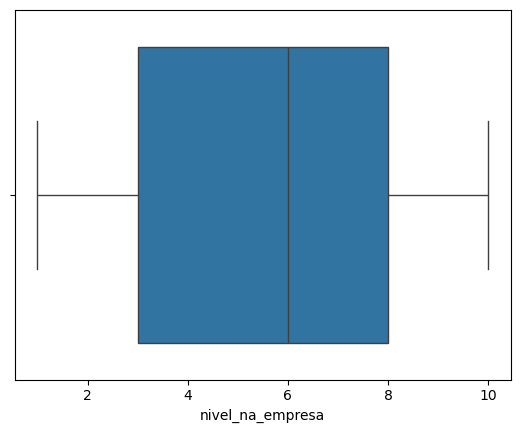

In [9]:
sns.boxplot(data=df_salary_eda,x='nivel_na_empresa')

<Axes: xlabel='salario_em_reais'>

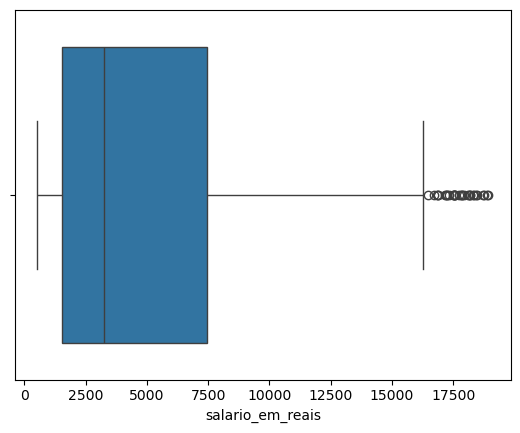

In [10]:
sns.boxplot(data=df_salary_eda,x='salario_em_reais')

<Axes: xlabel='tempo_na_empresa', ylabel='salario_em_reais'>

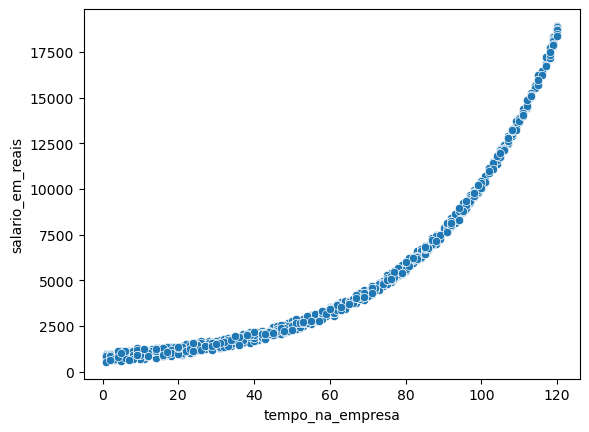

In [11]:
sns.scatterplot(df_salary_eda,x='tempo_na_empresa',y='salario_em_reais')

<Axes: xlabel='nivel_na_empresa', ylabel='salario_em_reais'>

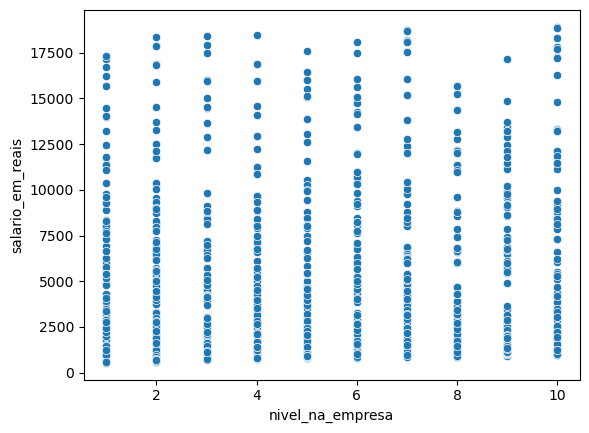

In [12]:
sns.scatterplot(df_salary_eda,x='nivel_na_empresa',y='salario_em_reais')

<Axes: xlabel='nivel_na_empresa', ylabel='tempo_na_empresa'>

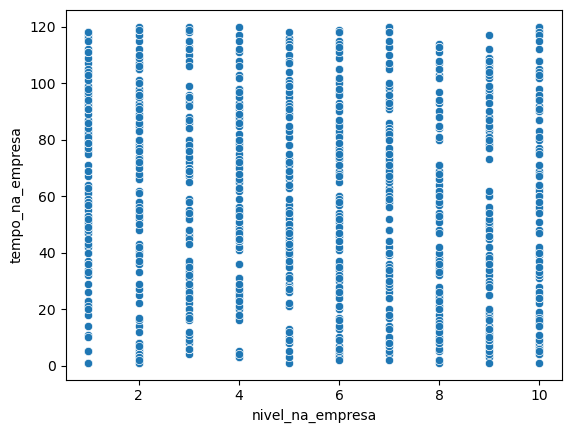

In [13]:
sns.scatterplot(df_salary_eda,x='nivel_na_empresa',y='tempo_na_empresa')

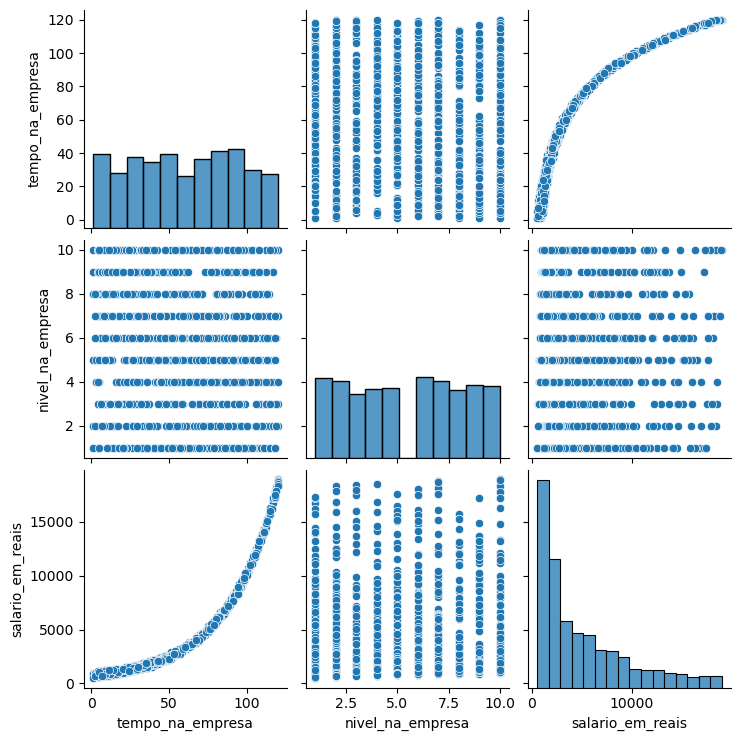

In [14]:
# Histograma das variáveis
sns.pairplot(df_salary_eda)

<Axes: >

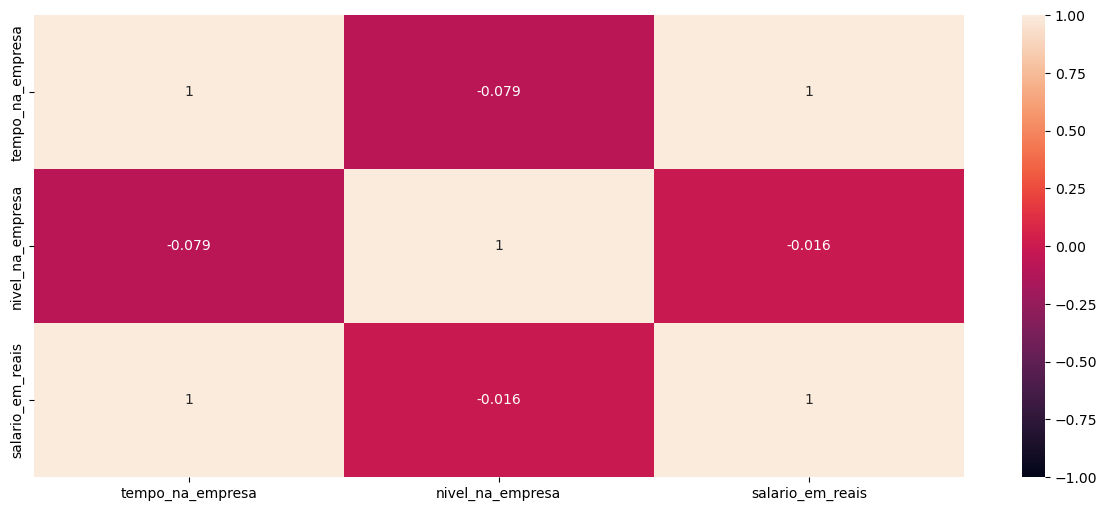

In [15]:
# Mapa de calor
plt.figure(figsize=(15,6))
sns.heatmap(df_salary_eda.corr('spearman'),vmin=-1,vmax=1,annot=True)

<Axes: >

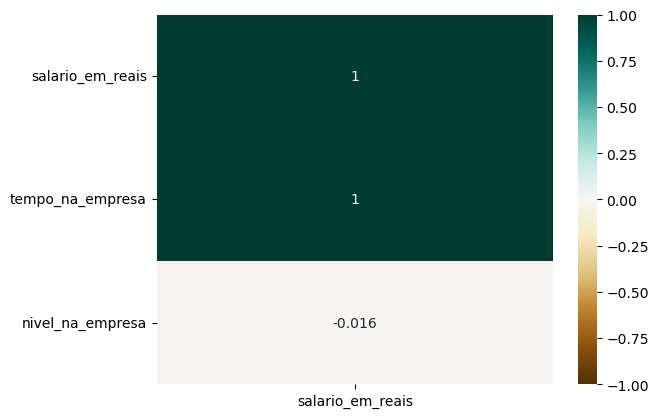

In [16]:

sns.heatmap(
	df_salary_eda.corr('spearman')[['salario_em_reais']]
	.sort_values(by='salario_em_reais',ascending=False),
	vmin=-1, vmax=1, annot=True, cmap='BrBG'
)

In [17]:
# Bucketing tempo de casa
bins_tempo_de_casa = [0,10,20,30,40,50,60,70,80,90,100,110,120,130]
labels_tempo_casa = ['0-9','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-99','100-109','110-119','120-129']

df_salary_bucketing['escala_tempo'] = pd.cut(x=df_salary_bucketing['tempo_na_empresa'], bins=bins_tempo_de_casa, labels=labels_tempo_casa, include_lowest=True)

In [18]:
df_salary_bucketing.head(10)

,tempo_na_empresa,nivel_na_empresa,salario_em_reais,escala_tempo
0,50,1,2288.13,40-49
1,49,4,2389.84,40-49
2,39,10,2158.73,30-39
3,51,1,2341.06,50-59
4,62,7,3584.20,60-69
5,105,10,12102.18,100-109
6,80,3,5723.35,70-79
7,85,2,6424.92,80-89
8,66,5,3916.18,60-69
9,73,5,4751.79,70-79


<Axes: xlabel='escala_tempo', ylabel='salario_em_reais'>

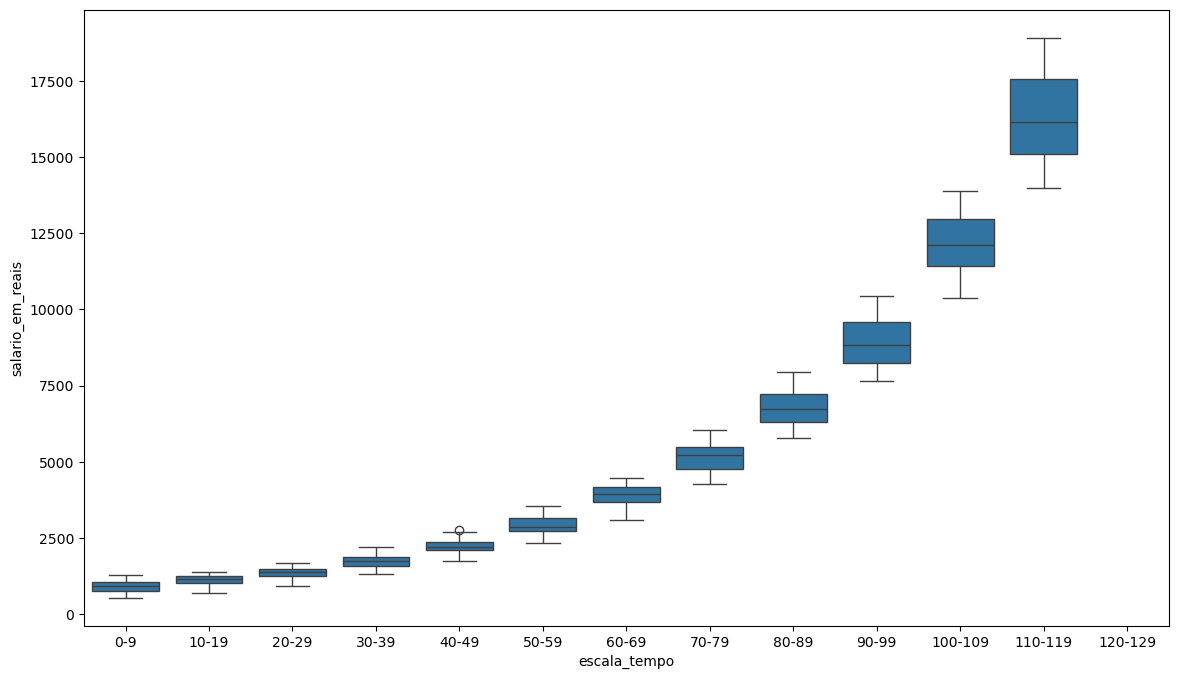

In [19]:
plt.figure(figsize=(14,8))
sns.boxplot(df_salary_bucketing,x='escala_tempo',y='salario_em_reais')

## Treinar o modelo linear

In [20]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error
import numpy as np



In [21]:
# Criar o Dataset de Treino e teste
X = df_salary.drop(columns='salario_em_reais',axis=1)
y = df_salary['salario_em_reais']

In [22]:
# Split usando KFold com 5 pastas/splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [23]:
kf
# kf.split() retorna um conjunto de indices

KFold(n_splits=5, random_state=42, shuffle=True)

In [24]:
# Bloco para treinamento do modelo

#Pipeline 
# Padronizar variáveis numéricas - tempo_na_empresa nivel_na_empresa
colunas_numericas = ['tempo_na_empresa','nivel_na_empresa']

# Transformer numéricas
transformer_numericas = Pipeline(
    steps=[
        ('scaler',StandardScaler())
    ]
)

# Criar um ColumnTransformer
preprocess = ColumnTransformer(
    transformers=[
        ('num',transformer_numericas,colunas_numericas)
    ]
)

# Criando o Pipeline principal = Pré- Processamento + treinamento
model_linear = Pipeline(
    steps=[
        ('preprocessor', preprocess),
        ('lin_model_reg', LinearRegression())
    ]
)

# Armazenar RMSE Treino e Teste (Para evitar overfitting)
rmse_scores_fold_train = []
rmse_scores_fold_test = []

# Armazenar R2 Score Teste 
r2score_fold_test = []

# Armazenar Resíduos
residuos = []

# Armazenar as predições
y_pred_total = []

# Já que o kf.split() retorna um conjunto de indices, podemos separar em treino e teste com uso do iloc
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Treine o conjunto de treinamento
    model_linear.fit(X_train, y_train)
    
    # Faça predições nos conjuntos de treinamento e teste
    y_train_pred = model_linear.predict(X_train)
    y_test_pred = model_linear.predict(X_test)
    y_pred_total.append(y_test_pred)
    
    # Calcule o RMSE para os conjuntos de treinamento e teste
    rmse_train = root_mean_squared_error(y_train,y_train_pred)
    rmse_test = root_mean_squared_error(y_test,y_test_pred)
    rmse_scores_fold_train.append(rmse_train)
    rmse_scores_fold_test.append(rmse_test)
    
    # Calcular o r2score
    r2score_test = r2_score(y_test,y_test_pred)
    r2score_fold_test.append(r2score_test)
    
    # Calcular os resíduos
    residuos_test = np.array(y_test - y_test_pred)
    residuos.append(residuos_test)

rmse_train_final = np.mean(rmse_scores_fold_train)
rmse_test_final = np.mean(rmse_scores_fold_test)
r2score_final = np.mean(r2score_fold_test)
percentual_rmse_final = ((rmse_test_final - rmse_train_final) / rmse_train_final) * 100

residuos = np.array(residuos).reshape(-1)
y_pred_total= np.array(y_pred_total).reshape(-1)


## Análise de métricas do modelo linear

In [25]:
# Métricas 
print(f'RMSE Treino: {rmse_train_final}')
print(f'RMSE Test: {rmse_test_final}')
print(f'% Dif. RMSE Treino e Teste: {percentual_rmse_final}')
print(f'R2Score Teste: {r2score_final}')


RMSE Treino: 1882.386843341482
RMSE Test: 1888.5627379751618
% Dif. RMSE Treino e Teste: 0.32808849336816975
R2Score Teste: 0.8257851479748144


## Análise de Resíduos - Modelo Linear 

In [26]:
# Transformar residuos na escala padrão
# (X - media) / desvio_padrao

from scipy.stats import zscore

residuos_std = zscore(residuos)

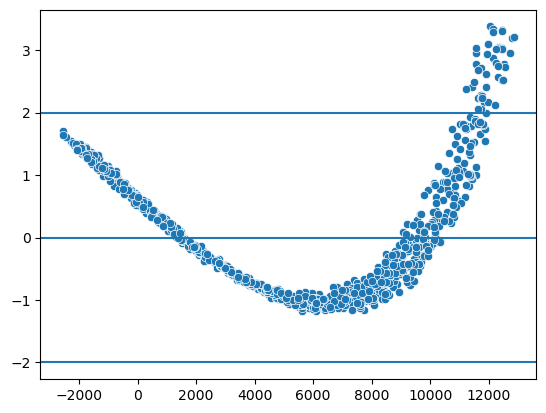

In [27]:
# Verificar a linearidade dos resíduos: Se os valores estão entre -2 e +2 (Escala padrão)
# Verificar homocedasticidade: Valores em torno da reta sem nenhuma tendência ou formato
sns.scatterplot(x=y_pred_total, y=residuos_std)
plt.axhline(0)
plt.axhline(-2)
plt.axhline(2)

#Não há linearidade e também não há homocedasticidade

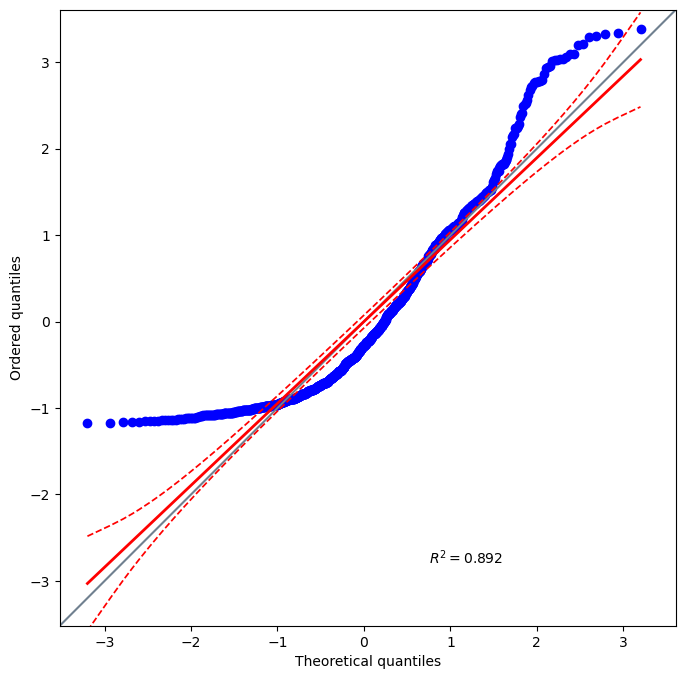

In [28]:
# Checar se residuos seguem uma distribuição normal
import pingouin as pg
plt.figure(figsize=(14,8))
plt.xlabel('Quantis Teóricos')
plt.ylabel('Resíduos na escala padrão')
pg.qqplot(x=residuos_std,dist='norm',confidence=0.95)
plt.show()

# Também não indica que os residuos seguem uma distribuição normal

In [29]:
from scipy.stats import shapiro, kstest
from statsmodels.stats.diagnostic import lilliefors

stat_shapiro, p_value_shapiro = shapiro(residuos_std)
print(f"Estatistica do Teste: {stat_shapiro} e p_value: {p_value_shapiro}")

Estatistica do Teste: 0.8912061634871188 e p_value: 5.834741850335806e-26


In [30]:
stat_ks, p_value_ks = kstest(residuos, 'norm')
print(f"Estatistica do Teste: {stat_ks} e p_value: {p_value_ks}")

Estatistica do Teste: 0.593 e p_value: 0.0


In [31]:
stat_ll, p_value_ll = lilliefors(residuos,'norm',pvalmethod='table')
print(f"Estatistica do Teste: {stat_ll} e p_value: {p_value_ll}")

Estatistica do Teste: 0.12046685747047076 e p_value: 0.0009999999999998899


In [32]:
# Todas as métricas sugerem que os resíduos não seguem uma distribuição normal, todos os p_value são menores do que 0.05

### Treinar o modelo Polinomial

In [38]:
# Exemplo de criação de features polinomiais
feat_poly = PolynomialFeatures(degree=3,include_bias=True)
X_poly = feat_poly.fit_transform(X)
feat_poly.feature_names_in_

array(['tempo_na_empresa', 'nivel_na_empresa'], dtype=object)

In [39]:
# Ver todas as features criadas (Passando as features de entrada)
feat_poly.get_feature_names_out(feat_poly.feature_names_in_)

array(['1', 'tempo_na_empresa', 'nivel_na_empresa', 'tempo_na_empresa^2',
       'tempo_na_empresa nivel_na_empresa', 'nivel_na_empresa^2',
       'tempo_na_empresa^3', 'tempo_na_empresa^2 nivel_na_empresa',
       'tempo_na_empresa nivel_na_empresa^2', 'nivel_na_empresa^3'],
      dtype=object)

In [45]:
# Bloco para treinamento do modelo

# graus_polynomial = [1,2,3,4,5,6,7,8,9,10] 4 apresentou o melhor valor

graus_polynomial = [4]

rmse_train_values = []
rmse_test_values = []
percentual_rmse_values = []
r2score_test_values = []

kf = KFold(n_splits=5,shuffle=True,random_state=42)

for grau in graus_polynomial:


    #Pipeline 
    # Padronizar variáveis numéricas - tempo_na_empresa nivel_na_empresa
    colunas_numericas = ['tempo_na_empresa','nivel_na_empresa']

    # Transformer numéricas
    transformer_numericas = Pipeline(
        steps=[
            ('scaler',StandardScaler())
        ]
    )

    # Criar um ColumnTransformer
    preprocess = ColumnTransformer(
        transformers=[
            ('num',transformer_numericas,colunas_numericas)
        ]
    )

    #Criar features polinomiais
    feat_poly = PolynomialFeatures(degree=grau,include_bias=False)

    # Criando o Pipeline principal = Pré- Processamento + treinamento
    model_poly = Pipeline(
        steps=[
            ('preprocessor', preprocess),
            ('poly_features', feat_poly),
            ('lin_model_reg', LinearRegression())
        ]
    )

    # Armazenar RMSE Treino e Teste (Para evitar overfitting)
    rmse_scores_fold_train = []
    rmse_scores_fold_test = []

    # Armazenar R2 Score Teste 
    r2score_fold_test = []

    # Armazenar Resíduos
    residuos = []

    # Armazenar as predições
    y_pred_total = []

    # Já que o kf.split() retorna um conjunto de indices, podemos separar em treino e teste com uso do iloc
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Treine o conjunto de treinamento
        model_poly.fit(X_train, y_train)
        
        # Faça predições nos conjuntos de treinamento e teste
        y_train_pred = model_poly.predict(X_train)
        y_test_pred = model_poly.predict(X_test)
        y_pred_total.append(y_test_pred)
        
        # Calcule o RMSE para os conjuntos de treinamento e teste
        rmse_train = root_mean_squared_error(y_train,y_train_pred)
        rmse_test = root_mean_squared_error(y_test,y_test_pred)
        rmse_scores_fold_train.append(rmse_train)
        rmse_scores_fold_test.append(rmse_test)
        
        # Calcular o r2score
        r2score_test = r2_score(y_test,y_test_pred)
        r2score_fold_test.append(r2score_test)
        
        # Calcular os resíduos
        residuos_test = np.array(y_test - y_test_pred)
        residuos.append(residuos_test)

    rmse_train_final = np.mean(rmse_scores_fold_train)
    rmse_test_final = np.mean(rmse_scores_fold_test)
    r2score_final = np.mean(r2score_fold_test)
    percentual_rmse_final = ((rmse_test_final - rmse_train_final) / rmse_train_final) * 100

    residuos = np.array(residuos).reshape(-1)
    y_pred_total= np.array(y_pred_total).reshape(-1)

    rmse_train_values.append(rmse_train_final)
    rmse_test_values.append(rmse_test_final)
    r2score_test_values.append(r2score_final)
    percentual_rmse_values.append(percentual_rmse_final)




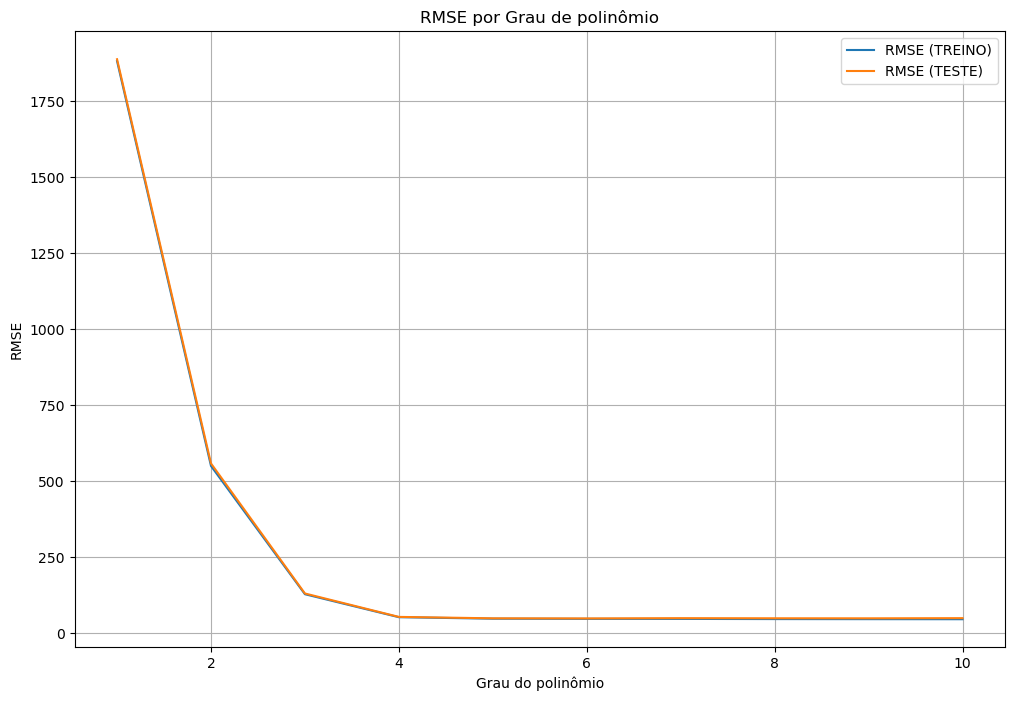

In [43]:
plt.figure(figsize=(12,8))
plt.plot(graus_polynomial, rmse_train_values, label='RMSE (TREINO)')
plt.plot(graus_polynomial, rmse_test_values, label='RMSE (TESTE)')
plt.xlabel('Grau do polinômio')
plt.ylabel('RMSE')
plt.title('RMSE por Grau de polinômio')
plt.legend()
plt.grid(True)
plt.show()


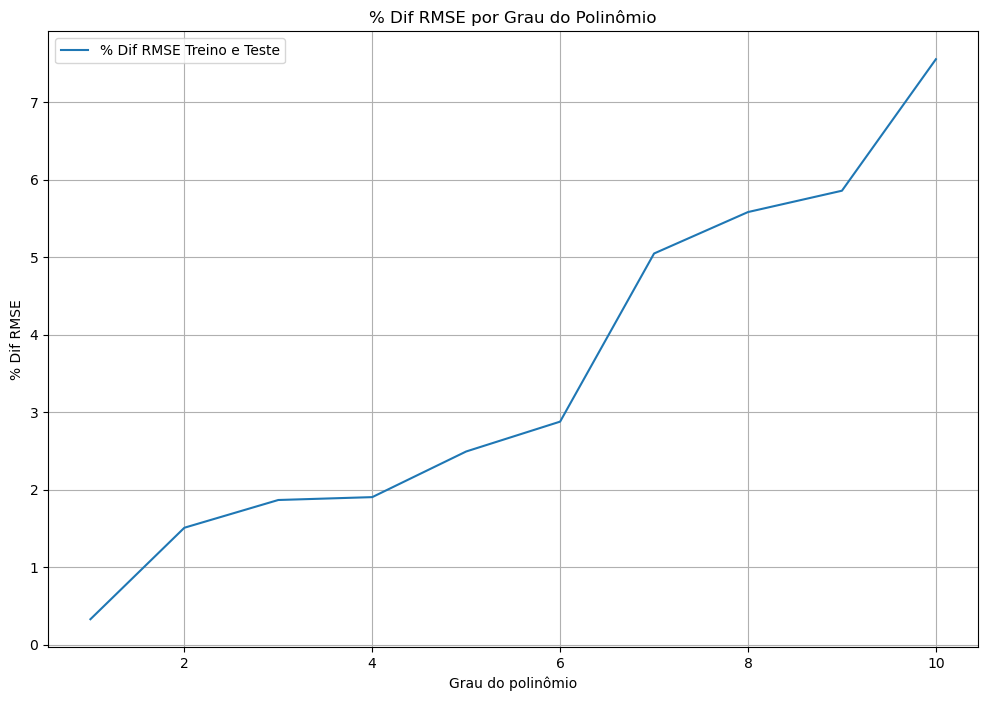

In [44]:
plt.figure(figsize=(12,8))
plt.plot(graus_polynomial, percentual_rmse_values, label='% Dif RMSE Treino e Teste')
plt.xlabel('Grau do polinômio')
plt.ylabel('% Dif RMSE')
plt.title('% Dif RMSE por Grau do Polinômio')
plt.legend()
plt.grid(True)
plt.show()

## Análise de Métricas - Modelo polinomial

In [46]:
# Métricas
print(f'RMSE Treino: {rmse_train_final}')
print(f'RMSE Test: {rmse_test_final}')
print(f'% Dif. RMSE Treino e Teste: {percentual_rmse_final}')
print(f'R2Score Teste: {r2score_final}')


RMSE Treino: 53.37779215581851
RMSE Test: 54.39425704747977
% Dif. RMSE Treino e Teste: 1.9042842549463836
R2Score Teste: 0.9998533313458712


## Análise de Resíduos - Modelo Polinomial 

In [47]:
# Transformar residuos na escala padrão
# (X - media) / desvio_padrao

from scipy.stats import zscore

residuos_std = zscore(residuos)

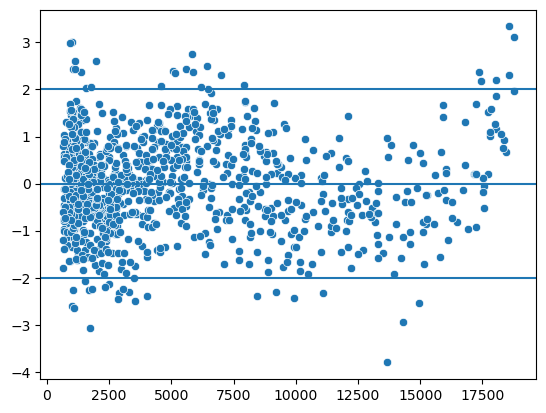

In [ ]:
# Verificar a linearidade dos resíduos: Se os valores estão entre -2 e +2 (Escala padrão)
# Verificar homocedasticidade: Valores em torno da reta sem nenhuma tendência ou formato
sns.scatterplot(x=y_pred_total, y=residuos_std)
plt.axhline(0)
plt.axhline(-2)
plt.axhline(2)


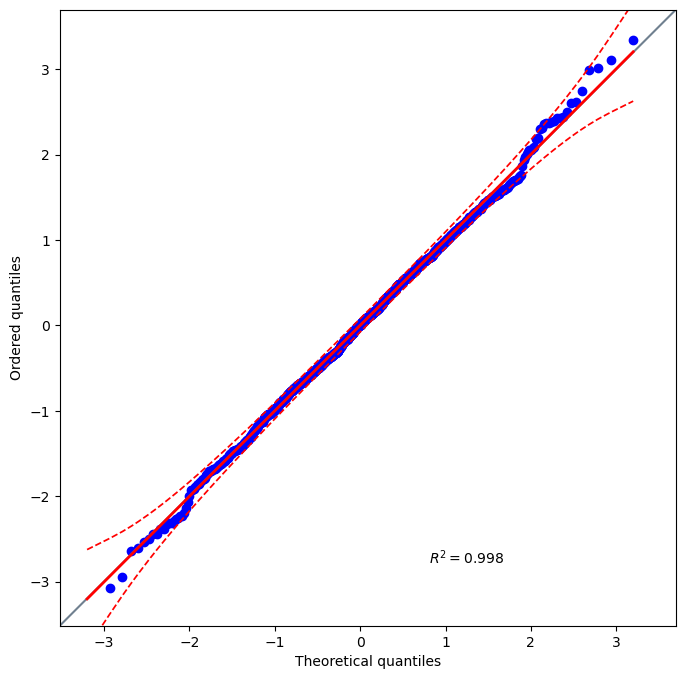

In [ ]:
# Checar se residuos seguem uma distribuição normal
import pingouin as pg
plt.figure(figsize=(14,8))
plt.xlabel('Quantis Teóricos')
plt.ylabel('Resíduos na escala padrão')
pg.qqplot(x=residuos_std,dist='norm',confidence=0.95)
plt.show()


In [50]:
from scipy.stats import shapiro, kstest
from statsmodels.stats.diagnostic import lilliefors

stat_shapiro, p_value_shapiro = shapiro(residuos_std)
print(f"Estatistica do Teste: {stat_shapiro} e p_value: {p_value_shapiro}")

Estatistica do Teste: 0.998537593628802 e p_value: 0.5793531253495575


In [51]:
stat_ks, p_value_ks = kstest(residuos, 'norm')
print(f"Estatistica do Teste: {stat_ks} e p_value: {p_value_ks}")

Estatistica do Teste: 0.4804789973633936 e p_value: 7.48207800940139e-213


In [52]:
stat_ll, p_value_ll = lilliefors(residuos,'norm',pvalmethod='table')
print(f"Estatistica do Teste: {stat_ll} e p_value: {p_value_ll}")

Estatistica do Teste: 0.0158273217983379 e p_value: 0.8443196149964318


In [53]:
# As métricas sugerem que os resíduos seguem uma distribuição normal

## Predições Individuais

In [54]:
input_features = {
    'tempo_na_empresa': 72,
    'nivel_na_empresa':10
}

pred_df = pd.DataFrame(input_features, index=[1])

In [55]:
# Predição
model_poly.predict(pred_df)

array([4804.6996693])

In [56]:
import joblib

In [57]:
joblib.dump(model_poly, './modelo_salario.pkl')

['./modelo_salario.pkl']